# Feature Engineering investigation

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_start = '2021-07-01 00:00:00'
train_end = '2021-07-15 23:00:00'
test_start = '2021-07-16 00:00:00'
test_end = '2021-07-29 23:00:00'

# get label
label = pd.read_pickle('/Users/rampageyao/Desktop/ARIMA_experiment_code/label.pkl')
train_label = pd.Series(label.loc[train_start:train_end].value)
test_label = pd.Series(label.loc[test_start:test_end].value)

# get feature matrix
features = pd.read_pickle('/Users/rampageyao/Desktop/ARIMA_experiment_code/2021_features.pkl')
train_features = features.loc[train_start:train_end]
test_features = features.loc[test_start:test_end]

In [2]:
print(f'Original feature size: {features.shape}')
print(f'Training feature size: {train_features.shape}')
print(f'Test feature size: {test_features.shape}')
print('------------------------------------------')
print(f'Original label size: {label.shape}')
print(f'Training label size: {train_label.shape}')
print(f'Test labl size: {test_label.shape}')

Original feature size: (5111, 786)
Training feature size: (360, 786)
Test feature size: (336, 786)
------------------------------------------
Original label size: (92784, 1)
Training label size: (360,)
Test labl size: (336,)


## First layer feature filtering

In [4]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(train_features);
features_filtered = select_features(train_features, train_label)
print(features_filtered.shape)

(360, 199)


## Second layer feature selection using Lasso Regression

In [5]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

def FeatureSelection(features_filtered, label):
    model = linear_model.Lasso(alpha=0.1)

    # standardization
    X = StandardScaler().fit_transform(np.array(features_filtered))
    y = np.array(label)
    model.fit(X, y)
    feature_coeff = pd.Series(model.coef_, index=features_filtered.columns)
    feature_coeff = feature_coeff.sort_values(ascending=False)
    feature_names = feature_coeff[feature_coeff.abs()>0.3].index
    return feature_names

In [6]:
relevant_feature_names = FeatureSelection(features_filtered, train_label)
train_X = StandardScaler().fit_transform(np.array(train_features[relevant_feature_names]))
test_X = StandardScaler().fit_transform(np.array(test_features[relevant_feature_names]))
print(train_X.shape)
print(test_X.shape)

(360, 36)
(336, 36)


## Training ARIMA model

In [302]:
from pmdarima import auto_arima
model = auto_arima(train_label, max_p=8, max_q=8, max_order=None, \
    seasonal=False, m=24, \
    exogenous=train_X, \
    trace=True, error_action="ignore", suppress_warnings=True, stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=3.69 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4336.743, Time=1.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=2.68 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=2.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1947.339, Time=3.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1946.968, Time=2.62 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=2.24 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1952.009, Time=3.52 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1960.224, Time=3.66 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=3.37 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1943.289, Time=4.43 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=1956.849, Time=3.56 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1943.815, Time=3.49 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1945.359, Time=3.38 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=1954.205, Time=3

In [303]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
preds = model.predict_in_sample(train_X)
print("Train RMSE: %.3f" % np.sqrt(mean_squared_error(train_label, preds)))
print(f"Train SMAPE: {round(100 - smape(train_label, preds), 1)}%")

Train RMSE: 3.121
Train SMAPE: 97.3%


Text(0, 0.5, 'Price (€)')

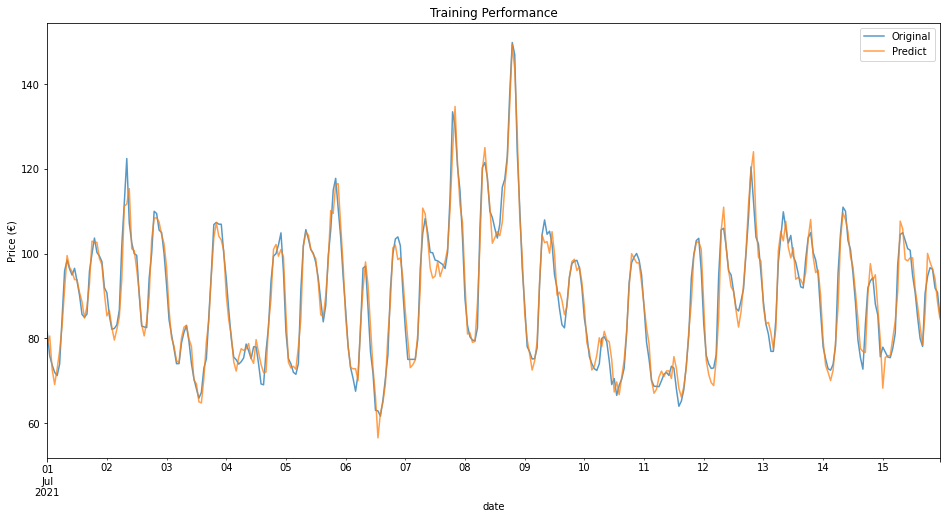

In [304]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(16,8))
train_label.plot(ax=ax, alpha=0.75)
forecast = pd.DataFrame({'date': train_label.index, 'value': preds}).set_index('date')
forecast.plot(ax=ax, alpha=0.75)  # Forecasts
# setting
ax.legend(['Original', 'Predict'])
plt.title("Training Performance")
plt.ylabel('Price (€)')

In [305]:
preds, conf_int = model.predict(n_periods=test_label.shape[0], X=test_X, return_conf_int=True)
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test_label, preds)))
print(f"Test SMAPE: {round(100 - smape(test_label, preds), 1)}%")

Test RMSE: 16.958
Test SMAPE: 78.8%


Text(0, 0.5, 'Price (€)')

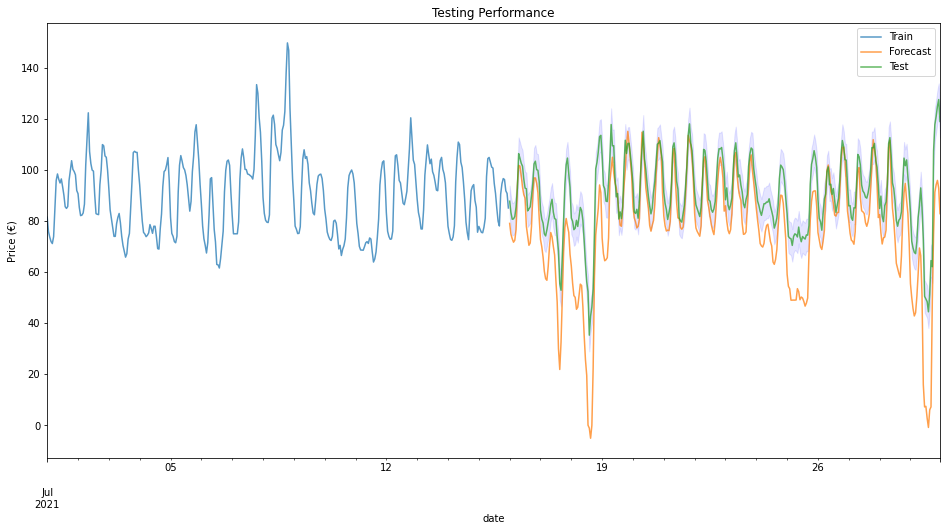

In [306]:
# visualization
fig, ax = plt.subplots(1,1,figsize=(16,8))
train_label.plot(ax=ax, alpha=0.75) # Training data
test_label.plot(ax=ax, alpha=0.75)  # Test data
forecast = pd.DataFrame({'date': test_label.index, 'value': preds}).set_index('date')
forecast.plot(ax=ax, alpha=0.75)  # Forecasts

# plot confidence interval
ax.fill_between(test_label.index, conf_int[:, 0], conf_int[:, 1], \
                  alpha=0.1, color='b')
plt.legend(['Train', 'Forecast', 'Test'])
plt.title("Testing Performance")
plt.ylabel('Price (€)')
# plt.xlim(['2011-03-01 23:00:00', '2011-04-02 23:00:00'])

## Cross Validation

In [307]:
# from sklearn.model_selection import TimeSeriesSplit
# n_split = 5
# n_periods = 336

# tscv = TimeSeriesSplit(n_splits=n_split, test_size=n_periods)
# val_model = pm.ARIMA(model.get_params()['order'])
# result = []
# count = 0
# for train_index, test_index in tscv.split(train_label):
#     train_val_label = train_label[train_index]
#     val_features = train_X[train_index]
#     test_val_label = train_label[test_index]

#     val_model.fit(train_val_label, val_features)
#     accuracy = 100-smape(test_val_label, val_model.predict(n_periods=n_periods, X=test_X))
#     result.append(accuracy)
#     count += 1
#     print(f'{count}/{n_split}: {accuracy}%')
    

In [308]:
from pmdarima.model_selection import SlidingWindowForecastCV, cross_validate
train_size = len(train_label)
test_size = len(test_label)
n_fold = 5
cv = SlidingWindowForecastCV(window_size=train_size-n_fold, step=1, h=test_size)
cv_result = cross_validate(model, \
    pd.concat([train_label, test_label]), \
    np.concatenate([train_X, test_X]), \
    scoring='smape', cv=cv, verbose=2)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................


In [309]:
print(f"mean: {round(100-cv_result['test_score'].mean(),1)}%")
print(f"std: {cv_result['test_score'].std()}")

mean: 79.0%
std: 0.16785622327773672
